<h1> Logistic Regression using Spark ML </h1>

Set up bucket

In [1]:
BUCKET='ai-analytics-solutions-dsongcp'  # CHANGE ME

import os
os.environ['BUCKET'] = BUCKET

In [2]:
# Create spark session

from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

print(spark)
print(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local appName=logistic>


In [3]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

<h2> Read dataset </h2>

In [4]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [5]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [6]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read.json(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

<h2> Clean up </h2>

In [7]:
trainquery = """
SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [8]:
print(traindata.head(2))  # if this is empty, try changing the shard you are using.

[Row(ARR_AIRPORT_LAT=33.43416667, ARR_AIRPORT_LON=-112.01166667, ARR_AIRPORT_TZOFFSET=-25200.0, ARR_DELAY=-16.0, ARR_TIME='2015-07-28T18:20:00', CANCELLED=False, CRS_ARR_TIME='2015-07-28T18:36:00', CRS_DEP_TIME='2015-07-28T17:05:00', DEP_AIRPORT_LAT=33.9425, DEP_AIRPORT_LON=-118.40805556, DEP_AIRPORT_TZOFFSET=-25200.0, DEP_DELAY=-3.0, DEP_TIME='2015-07-28T17:02:00', DEST='PHX', DEST_AIRPORT_SEQ_ID='1410702', DISTANCE='370.00', DIVERTED=False, FL_DATE='2015-07-28', ORIGIN='LAX', ORIGIN_AIRPORT_SEQ_ID='1289203', TAXI_IN=6.0, TAXI_OUT=14.0, UNIQUE_CARRIER='AA', WHEELS_OFF='2015-07-28T17:16:00', WHEELS_ON='2015-07-28T18:14:00'), Row(ARR_AIRPORT_LAT=33.43416667, ARR_AIRPORT_LON=-112.01166667, ARR_AIRPORT_TZOFFSET=-25200.0, ARR_DELAY=12.0, ARR_TIME='2015-07-28T21:25:00', CANCELLED=False, CRS_ARR_TIME='2015-07-28T21:13:00', CRS_DEP_TIME='2015-07-28T19:40:00', DEP_AIRPORT_LAT=33.9425, DEP_AIRPORT_LON=-118.40805556, DEP_AIRPORT_TZOFFSET=-25200.0, DEP_DELAY=24.0, DEP_TIME='2015-07-28T20:04:00', 

In [36]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [37]:
traindata.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+
|summary|         DEP_DELAY|         TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+-----------------+-----------------+-----------------+
|  count|            211855|           211667|           211144|           216573|
|   mean|10.054159684690001|15.85331676643029|5.404321221536013|835.8613631431434|
| stddev| 40.26571628278374|9.020269569048152|43.24505614071096|600.3501910195829|
|    min|             -36.0|              1.0|            -87.0|          1005.00|
|    max|            1461.0|            174.0|           1460.0|           998.00|
+-------+------------------+-----------------+-----------------+-----------------+



Note that the counts for the various columns are all different; We have to remove NULLs in the delay variables (these correspond to canceled or diverted flights).

<h2> Logistic regression </h2>

In [10]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [13]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == 'False' AND 
  f.DIVERTED == 'False'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



In [14]:
def to_example(fields):
    return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [15]:
examples = traindata.rdd.map(to_example)

In [16]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print(lrmodel.weights,lrmodel.intercept)

21/10/12 04:10:06 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/12 04:10:07 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


[-0.17926510230641074,-0.1353410840270897,0.00047781052266304745] 5.403405250989946


In [17]:
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

1
0


In [18]:
lrmodel.clearThreshold()
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

0.9520080900763146
0.08390675828170738


In [19]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

1
0


<h2> Predict with the model </h2>

First save the model

In [20]:
!gsutil -m rm -r gs://$BUCKET/flights/sparkmloutput/model

CommandException: 1 files/objects could not be removed.


In [21]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'

In [22]:
lrmodel.save(sc, MODEL_FILE)
print('{} saved'.format(MODEL_FILE))

gs://ai-analytics-solutions-dsongcp/flights/sparkmloutput/model saved


In [23]:
lrmodel = 0
print(lrmodel)

0


Now retrieve the model

In [24]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [25]:
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [26]:
print(lrmodel.predict([8.0,4.0,594.0]))

1


<h2> Examine the model behavior </h2>

For dep_delay=20 and taxiout=10, how does the distance affect prediction?

In [27]:
lrmodel.clearThreshold() # to make the model produce probabilities
print(lrmodel.predict([20, 10, 500]))

0.6689849289476673


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

Text(0, 0.5, 'probability of ontime arrival')

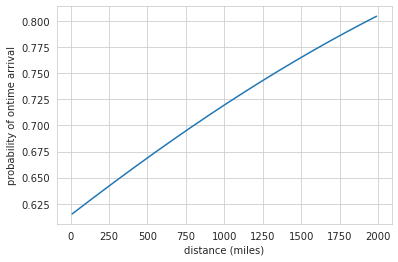

In [29]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

Text(0, 0.5, 'probability of ontime arrival')

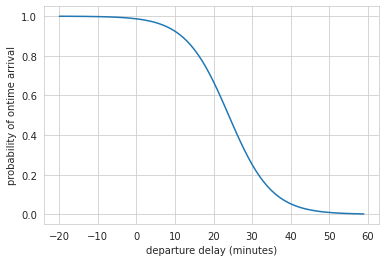

In [30]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

<h2> Evaluate model </h2>

Evaluate on the test data

In [31]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET) # 1/30th
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")
print(testquery)


SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.CANCELLED == 'False' AND 
  f.DIVERTED == 'False'



In [32]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [33]:
testdata.describe().show()  # if this is empty, change the shard you are using

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             82184|             82184|             82184|            82184|
|   mean| 8.674377007690062|15.676676725396671|3.8409179402316753|838.9512557188747|
| stddev|38.764341740364586| 8.505730543334973| 41.25995960185183|600.3088554927516|
|    min|             -35.0|               1.0|             -70.0|          1005.00|
|    max|            1576.0|             154.0|            1557.0|           998.00|
+-------+------------------+------------------+------------------+-----------------+



In [34]:
def eval(labelpred):
    ''' 
        data = (label, pred)
            data[0] = label
            data[1] = pred
    '''
    cancel = labelpred.filter(lambda data: data[1] < 0.7)
    nocancel = labelpred.filter(lambda data: data[1] >= 0.7)
    corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

In [35]:
# Evaluate model
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print('All flights:')
print(eval(labelpred))

# keep only those examples near the decision threshold
print('Flights near decision threshold:')
labelpred = labelpred.filter(lambda data: data[1] > 0.65 and data[1] < 0.75)
print(eval(labelpred))

All flights:


{'total_cancel': 14689, 'correct_cancel': 0.8239498944788617, 'total_noncancel': 67495, 'correct_noncancel': 0.9556411586043411}
Flights near decision threshold:


{'total_cancel': 714, 'correct_cancel': 0.3711484593837535, 'total_noncancel': 850, 'correct_noncancel': 0.6788235294117647}


Copyright 2019-2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.